1. Import the dataset and ensure that it loaded properly.
2. Prepare the data for modeling by performing the following steps:

* Drop the column “Load_ID.”
* Drop any rows with missing data.

In [4]:
import pandas as pd
loan = pd.read_csv("Loan_Train.csv")
loan = loan.drop('Loan_ID', axis=1)

def action_shape(label,data):
    row_count,column_count = data.shape
    print("{}, there are {} rows and {} columns.".format(label,row_count,column_count))

action_shape("Including rows with missing data",loan)
loan = loan.dropna()
action_shape("After dropping rows with missing data",loan)
loan.head()

Including rows with missing data, there are 614 rows and 12 columns.
After dropping rows with missing data, there are 480 rows and 12 columns.


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


* Convert the categorical features into dummy variables.

In [10]:
import re

def safe_column(input):
    result = str(input).strip()
    result = result.lower()

    # convert special characters and whitespace to "_"
    result = re.sub(r"[^a-z0-9_]", "_", result)

    # reduce adjacent "_" characters
    result = re.sub(r"_+", "_", result) 
    
    result = re.sub(r"^_", "", result) # remove leading "_"
    result = re.sub(r"_$", "", result) # remove trailing "_"
    if not result:
        result = "none"
    return result

def make_dummies(df,column):
    dummies = pd.get_dummies(df[column]).rename( \
        columns=lambda x: column + '_' + safe_column(x))
    df = pd.concat([df, dummies], axis=1)
    df.drop([column], inplace=True, axis=1)
    return df

In [26]:
# Note: "Dependents" is a categorical column because of the "3+" value.
categorical = [
    "Dependents",
    "Gender",
    "Married",
    "Education",
    "Self_Employed",
    "Property_Area",
    "Loan_Status"
]
with_dummies = loan.copy()
for column in categorical:
    with_dummies = make_dummies(with_dummies,column)
    print("Shape after converting "+column+" into dummy columns:", \
          with_dummies.shape)

# Remove duplicate inverse columns
with_dummies = with_dummies.rename(columns={
    "Self_Employed_yes": "Self_Employed",
    "Loan_Status_y": "Loan_Status",
    "Married_yes": "Married",
    })
with_dummies.drop(["Self_Employed_no"], inplace=True, axis=1)
with_dummies.drop(["Loan_Status_n"], inplace=True, axis=1)
with_dummies.drop(["Married_no"], inplace=True, axis=1)

# Convert "Loan_Status" to an int, since we will be using it as a target column
with_dummies['Loan_Status'] = with_dummies['Loan_Status'].astype(int)

with_dummies.head()

Shape after converting Dependents into dummy columns: (480, 15)
Shape after converting Gender into dummy columns: (480, 16)
Shape after converting Married into dummy columns: (480, 17)
Shape after converting Education into dummy columns: (480, 18)
Shape after converting Self_Employed into dummy columns: (480, 19)
Shape after converting Property_Area into dummy columns: (480, 21)
Shape after converting Loan_Status into dummy columns: (480, 22)


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Dependents_0,Dependents_1,Dependents_2,Dependents_3,Gender_female,Gender_male,Married,Education_graduate,Education_not_graduate,Self_Employed,Property_Area_rural,Property_Area_semiurban,Property_Area_urban,Loan_Status
1,4583,1508.0,128.0,360.0,1.0,False,True,False,False,False,True,True,True,False,False,True,False,False,0
2,3000,0.0,66.0,360.0,1.0,True,False,False,False,False,True,True,True,False,True,False,False,True,1
3,2583,2358.0,120.0,360.0,1.0,True,False,False,False,False,True,True,False,True,False,False,False,True,1
4,6000,0.0,141.0,360.0,1.0,True,False,False,False,False,True,False,True,False,False,False,False,True,1
5,5417,4196.0,267.0,360.0,1.0,False,False,True,False,False,True,True,True,False,True,False,False,True,1


3. Split the data into a training and test set, where the “Loan_Status” column is the target.

In [156]:
from sklearn.model_selection import train_test_split

copy = with_dummies.copy()
target_column = "Loan_Status"

data = copy.drop(target_column, axis=1)
target = copy[target_column]

# Split the data into 80% training and 20% testing
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=42)

print(data_train.shape, data_test.shape)
print(target_train.shape, target_test.shape)

(384, 18) (96, 18)
(384,) (96,)


4. Create a pipeline with a min-max scaler and a KNN classifier (see section 15.3 in the Machine Learning with Python Cookbook).

In [157]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Transform data features into 0-1 ranges.
mm_scaler = MinMaxScaler()

# KNN Classifier
knn = KNeighborsClassifier()

# Pipeline
pipe = Pipeline([("standardizer",mm_scaler),("knn",knn)])

5. Fit a default KNN classifier to the data with this pipeline. Report the model accuracy on the test set. Note: Fitting a pipeline model works just like fitting a regular model.

In [158]:
# This is my model accuracy metrics function from previous weeks.
import numpy as np
import sklearn.metrics as metrics

def print_model_metrics(test,pred):
    mae = metrics.mean_absolute_error(test, pred)
    mse = metrics.mean_squared_error(test, pred)
    rmse = np.sqrt(mse) # or mse**(0.5)  
    r2 = metrics.r2_score(test, pred)
    
    print("R-Squared:", r2)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolue Error (MAE): ",mae)

from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def display_classification_metrics(test,prediction):
    print("Accuracy: ",accuracy_score(test,prediction))
    
    print("Confusion Matrix: ")
    confusion = confusion_matrix(test,prediction)
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = [0, 1])
    cm_display.plot()
    plt.show()

    precision = precision_score(test,prediction)
    recall = recall_score(test,prediction)
    f1 = f1_score(test,prediction)
    
    print("Precision:", precision)
    print("Recall:", recall)
    print("F-1 Score:", f1)

MinMax+KNN(5) Pipeline Model Metrics:
R-Squared: -0.10924369747899143
Root Mean Squared Error (RMSE): 0.47871355387816905
Mean Absolue Error (MAE):  0.22916666666666666
Accuracy:  0.7708333333333334
Confusion Matrix: 


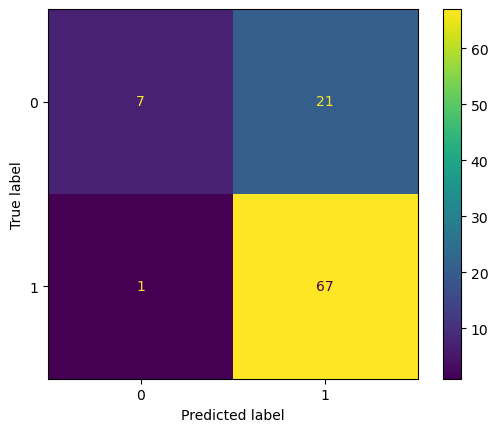

Precision: 0.7613636363636364
Recall: 0.9852941176470589
F-1 Score: 0.8589743589743591


In [159]:
# Fit the data to the pipeline
pipe.fit(data_train,target_train)

# Obtain the predictions
target_pred = pipe.predict(data_test)

print("MinMax+KNN(5) Pipeline Model Metrics:")
print_model_metrics(target_test,target_pred)
display_classification_metrics(target_test,target_pred)

6. Create a search space for your KNN classifier where your “n_neighbors” parameter varies from 1 to 10. (see section 15.3 in the Machine Learning with Python Cookbook).
7. Fit a grid search with your pipeline, search space, and 5-fold cross-validation to find the best value for the “n_neighbors” parameter.

In [160]:
from sklearn.model_selection import GridSearchCV

# Create candidate values for k
search = [{"knn__n_neighbors":[1,2,3,4,5,6,7,8,9,10]}]

# Grid Search for best value of k
classifier = GridSearchCV(
    pipe,
    search,
    cv=5,
    verbose=0,
    ).fit(data_train, target_train)

best_k = classifier.best_estimator_.get_params()["knn__n_neighbors"]
print("Best value for k: ",best_k)

Best value for k:  3


8. Find the accuracy of the grid search best model on the test set. Note: It is possible that this will not be an improvement over the default model, but likely it will be.

MinMax+KNN(3) Pipeline Model Metrics:
R-Squared: -0.10924369747899143
Root Mean Squared Error (RMSE): 0.47871355387816905
Mean Absolue Error (MAE):  0.22916666666666666
Accuracy:  0.7708333333333334
Confusion Matrix: 


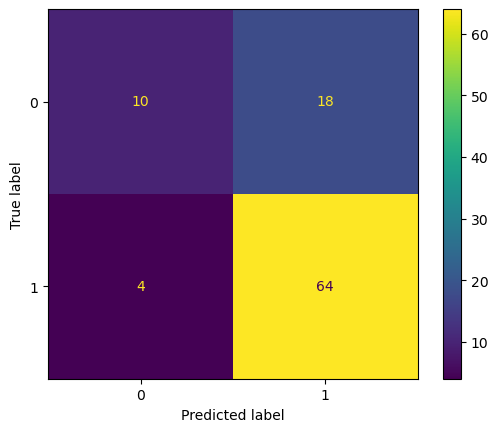

Precision: 0.7804878048780488
Recall: 0.9411764705882353
F-1 Score: 0.8533333333333334


In [161]:
# KNN Classifier
knn_3 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# Pipeline
pipe_3 = Pipeline([("standardizer",mm_scaler),("knn",knn_3)])

# Fit the data to the pipeline
pipe_3.fit(data_train,target_train)

# Obtain the predictions
target_pred = pipe_3.predict(data_test)

print("MinMax+KNN(3) Pipeline Model Metrics:")
print_model_metrics(target_test,target_pred)
display_classification_metrics(target_test,target_pred)


Note: I ran this manually on the test split and got a different best value for k. So I repeated this exercise several times, and even went up to where I'm splitting the test and train data to make it random. I noticed that on some splits certain values of k were very accurate, but not always. Out of several attempts with different splits and even running the full data through the GridSearch, it does seem that k=3 is the most generalizable, best value.

9. Now, repeat steps 6 and 7 with the same pipeline, but expand your search space to include logistic regression and random forest models with the hyperparameter values in section 12.3 of the Machine Learning with Python Cookbook.

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Pipeline
pipe = Pipeline([("standardizer",mm_scaler),("classifier",KNeighborsClassifier())])

# Create candidate values for k
search = [
    {
        "classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors":[1,2,3,4,5,6,7,8,9,10]
    },
    {
        'classifier':[LogisticRegression(max_iter=500,solver='liblinear')],
        'classifier__penalty': ['l1','l2'],
        'classifier__C':np.logspace(0,4,10)
    },{
        'classifier':[RandomForestClassifier()],
        'classifier__n_estimators':[10,100,1000],
        'classifier__max_features':[1,2,3]
    }
]


# Grid Search for best value of k
classifier = GridSearchCV(
    pipe,
    search,
    cv=5,
    verbose=0,
    ).fit(data_train, target_train)

10. What are the best model and hyperparameters found in the grid search? Find the accuracy of this model on the test set.

In [131]:
print("This pipeline resulted in the best overall accuracy:\n","   ",classifier.best_estimator_)

This pipeline resulted in the best overall accuracy:
     Pipeline(steps=[('standardizer', MinMaxScaler()),
                ('classifier',
                 LogisticRegression(C=7.742636826811269, max_iter=500,
                                    penalty='l1', solver='liblinear'))])


LogisticRegression Pipeline Model Metrics:
R-Squared: 0.1428571428571429
Root Mean Squared Error (RMSE): 0.4208127057650866
Mean Absolue Error (MAE):  0.17708333333333334
Accuracy:  0.8229166666666666
Confusion Matrix: 


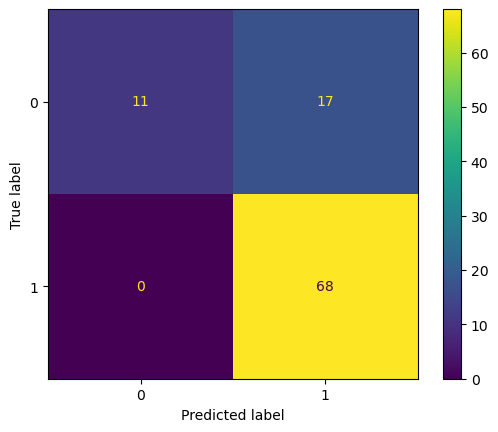

Precision: 0.8
Recall: 1.0
F-1 Score: 0.888888888888889


In [163]:
# Best Classifier
best_classifier = LogisticRegression(
    C=7.742636826811269, 
    max_iter=500,
    penalty='l1',
    solver='liblinear'
)

# Pipeline
best_pipe = Pipeline([("standardizer",mm_scaler),("classifier",best_classifier)])

# Fit the data to the pipeline
best_pipe.fit(data_train,target_train)

# Obtain the predictions
target_pred = best_pipe.predict(data_test)

print("LogisticRegression Pipeline Model Metrics:")
print_model_metrics(target_test,target_pred)
display_classification_metrics(target_test,target_pred)

11. Summarize your results.

I found strange behavior when testing for the best value for k (from the book, ch 15.3). I got a different value from testing the data manually than I did from the grid search. I did some more testing and I think this is the result of cross-validation during the grid-search. Effectively, the grid search is doing more splits than the simple test-train split I was doing. Those other splits were informing the accuracy of the model that was selected. So there are accuracy values that the grid search is considering that I'm not. If I could do all the CV splits, I'd see the same accuracy comparison that grid search is doing.

What underscored this for me was when I started modifying the "random_state" parameter I was passing into the test-train split. I ended up getting different results from the grid search based on how the data was split. Out of curiosity, I fed the whole dataset to the grid search since it was doing its own test-train splits internally. All of these results point to a level of unpredictability with this dataset when it comes to trying to model it using KNN.

For me, the investigation of this strange behavior underscores the need to retain a final test set from the data and not feed all the data to the grid search. This will allow you to see how generalizable the "best" model truly is. In this case, I don't think that KNN is a stable model for this dataset.

I didn't have the time to do a similar testing on the larger grid search using multiple models, but that grid search did produce a model with better accuracy than any of the accuracies I'd gotten from the KNN grid searches I had done. I would suspect that LogisitcRegression is a better classifier for this data than KNN, in terms of generalizing to other data.